# Projet AIRBNB ATHANAEL SAUTEREAU GUILLAUME SCHEID

1. Importation des bibliothèques

In [2]:
# Bibliothèques de base
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Préprocessing et modélisation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

plt.style.use('seaborn')  # Améliorer le style des graphiques

C:\Users\saute\AppData\Local\Temp\ipykernel_29908\2003391518.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Améliorer le style des graphiques


2. Chargement des données

In [3]:
# Charger le jeu d'entraînement
train_data = pd.read_csv("airbnb_train.csv")  # Chemin simplifié
print("Dimensions des données :", train_data.shape)

Dimensions des données : (22234, 28)


3. Exploration des types de données

In [4]:
# Afficher les types de variables et exemples de valeurs
print("=== Types des variables ===")
display(train_data.dtypes.to_frame(name="Type"))

print("\n=== Exemples de valeurs par colonne ===")
for col in train_data.select_dtypes(include='object').columns:
    print(f"{col} : {train_data[col].unique()[:5]}")  # Afficher 5 valeurs uniques

=== Types des variables ===


,Type
id,int64
log_price,float64
property_type,object
room_type,object
amenities,object
accommodates,int64
bathrooms,float64
bed_type,object
cancellation_policy,object
cleaning_fee,bool



=== Exemples de valeurs par colonne ===
property_type : ['House' 'Apartment' 'Townhouse' 'Guest suite' 'Condominium']
room_type : ['Private room' 'Entire home/apt' 'Shared room']
amenities : ['{TV,"Wireless Internet",Kitchen,"Free parking on premises","Pets allowed","Suitable for events",Washer,Dryer,"Smoke detector",Essentials,Shampoo,"Lock on bedroom door",Hangers,"Hair dryer",Iron}'
 '{"Wireless Internet","Air conditioning",Kitchen,Heating,"Family/kid friendly","Smoke detector","Carbon monoxide detector","Fire extinguisher",Essentials,"Lock on bedroom door","24-hour check-in","Hair dryer",Iron,"translation missing: en.hosting_amenity_50","Self Check-In",Keypad,"Bed linens",Microwave,"Coffee maker",Refrigerator,"Dishes and silverware","Cooking basics",Oven,Stove,"Luggage dropoff allowed"}'
 '{TV,"Wireless Internet","Air conditioning",Kitchen,"Free parking on premises","Pets allowed","Elevator in building",Heating,"Family/kid friendly",Washer,Dryer,"Smoke detector","Carbon monoxide d

4. Visualisations initiales (nouveau)

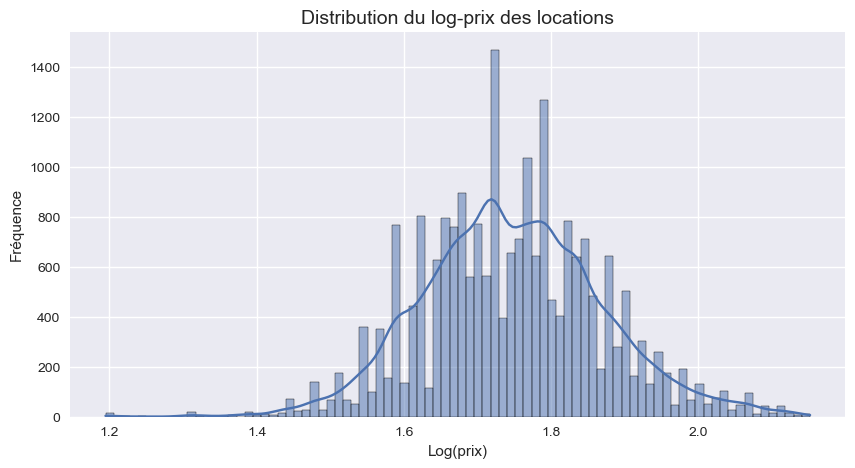

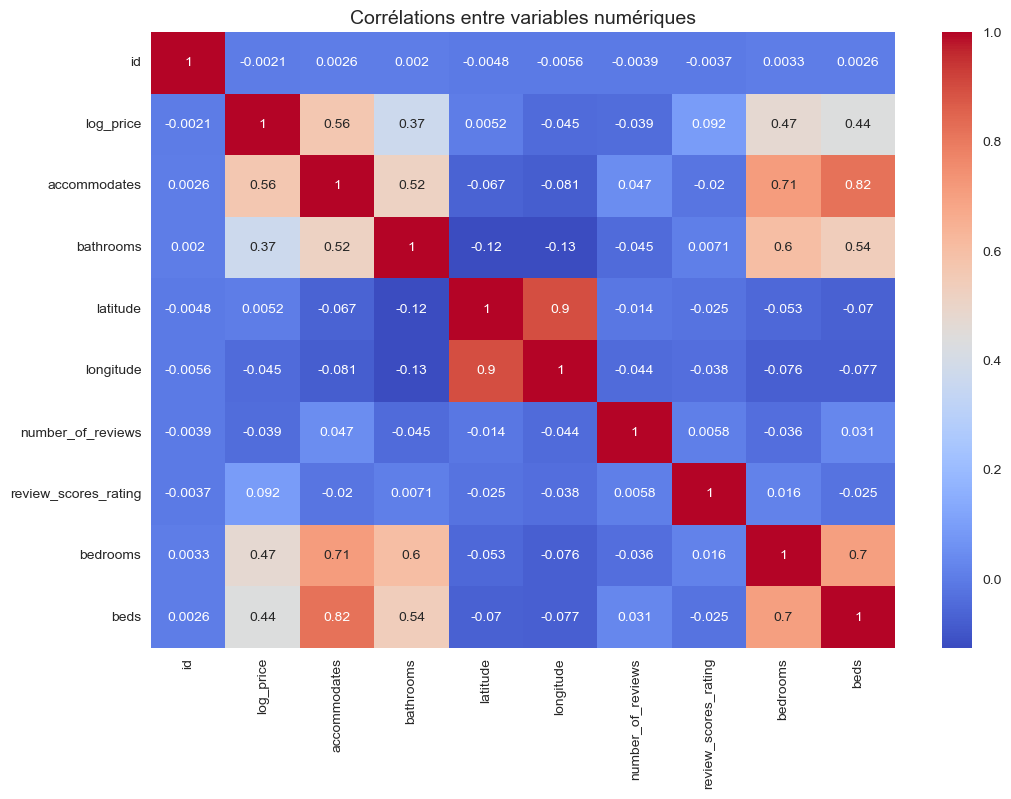

In [6]:
# Distribution du prix (cible)
plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(train_data['log_price']), kde=True)  # Log-prix pour normaliser
plt.title("Distribution du log-prix des locations", fontsize=14)
plt.xlabel("Log(prix)")
plt.ylabel("Fréquence")
plt.show()

# Matrice de corrélation (exemple)
num_cols = train_data.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(12, 8))
sns.heatmap(train_data[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Corrélations entre variables numériques", fontsize=14)
plt.show()

5. Nettoyage initial des données

In [7]:
# Suppression des colonnes avec >30% de valeurs manquantes
threshold = 0.3
train_data = train_data.loc[:, train_data.isna().mean() < threshold]

# Suppression des doublons
train_data = train_data.drop_duplicates().reset_index(drop=True)

6. Prétraitement des caractéristiques

In [8]:
# Conversion des dates
date_cols = ["first_review", "last_review", "host_since"]
train_data[date_cols] = train_data[date_cols].apply(pd.to_datetime, errors='coerce')

# Nettoyage des pourcentages
train_data["host_response_rate"] = (
    train_data["host_response_rate"]
    .str.replace("%", "", regex=False)
    .astype(float)
)

7. Analyse exploratoire des variables clés

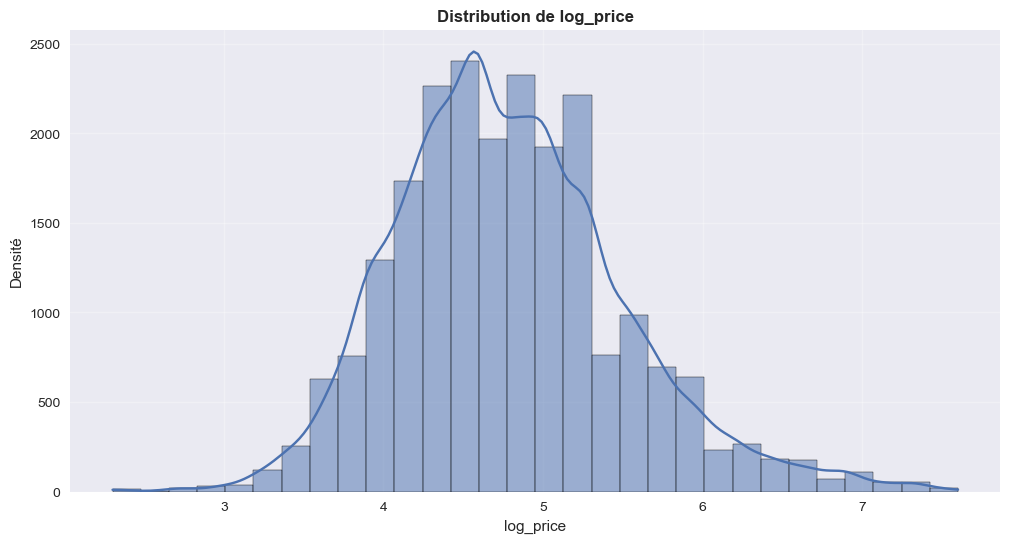

Statistiques log_price:
Moyenne: 4.78
Variance: 0.52



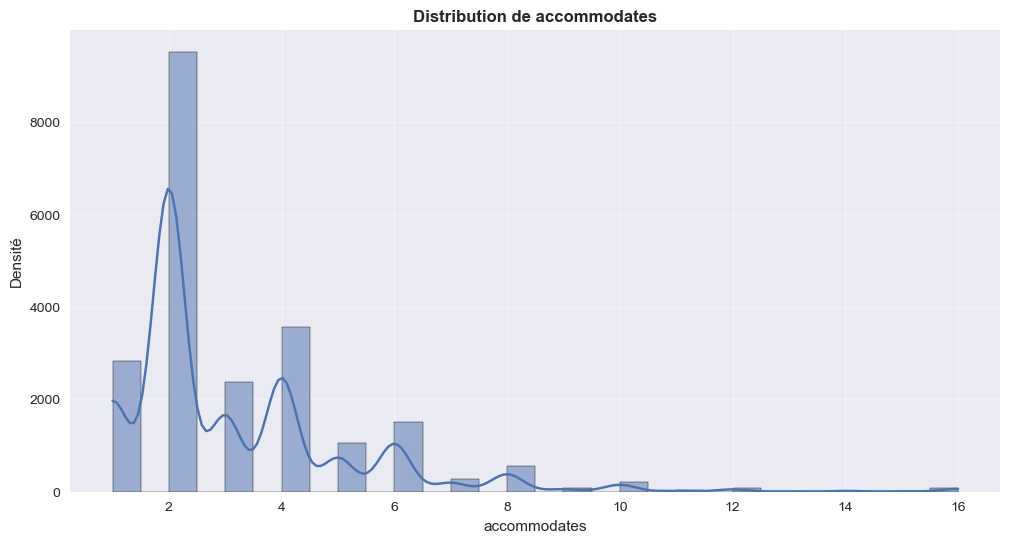

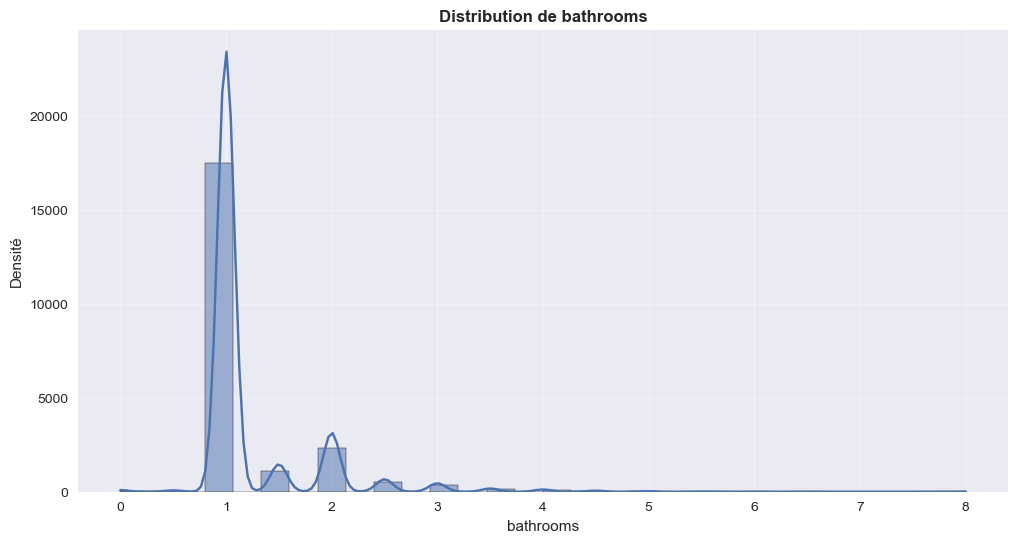

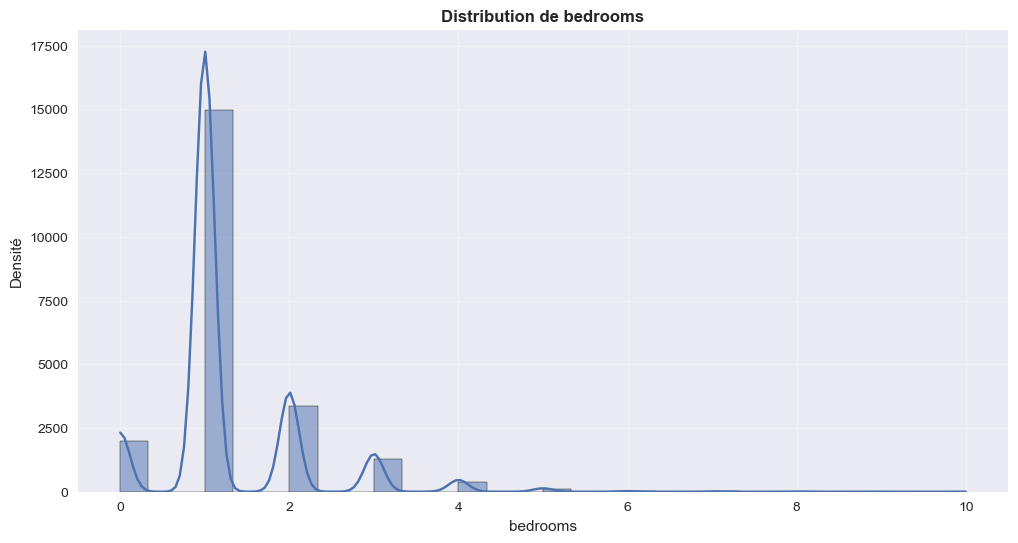

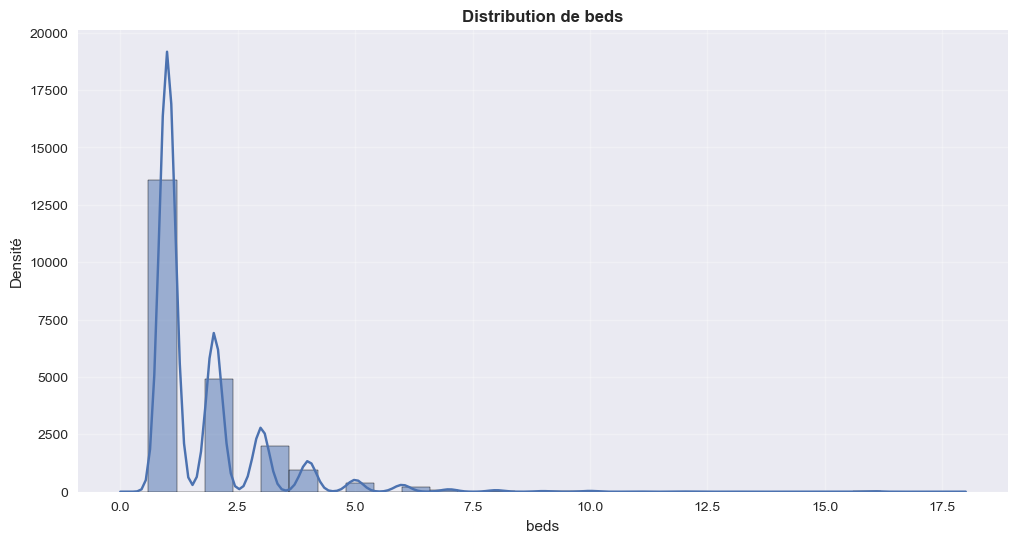

In [10]:
# Configuration des graphiques
plt.rcParams.update({'font.size': 12})
FIG_SIZE = (12, 6)

# Fonction générique pour les distributions
def plot_distribution(data, column, log_transform=False):
    plt.figure(figsize=FIG_SIZE)
    values = data[column].dropna()
    
    if log_transform:
        values = np.log1p(values)
        xlabel = f"Log({column})"
    else:
        xlabel = column
    
    sns.histplot(values, kde=True, bins=30)
    plt.title(f"Distribution de {column}", fontweight='bold')
    plt.xlabel(xlabel)
    plt.ylabel("Densité")
    plt.grid(alpha=0.3)
    plt.show()
    
    return values.mean(), values.var()

# Analyse de la variable cible
mean_logprice, var_logprice = plot_distribution(train_data, "log_price")
print(f"Statistiques log_price:\nMoyenne: {mean_logprice:.2f}\nVariance: {var_logprice:.2f}\n")

# Analyse des principales variables numériques
for col in ["accommodates", "bathrooms", "bedrooms", "beds"]:
    plot_distribution(train_data, col)
    plt.show()

8. Analyse des relations variables catégorielles/log_price

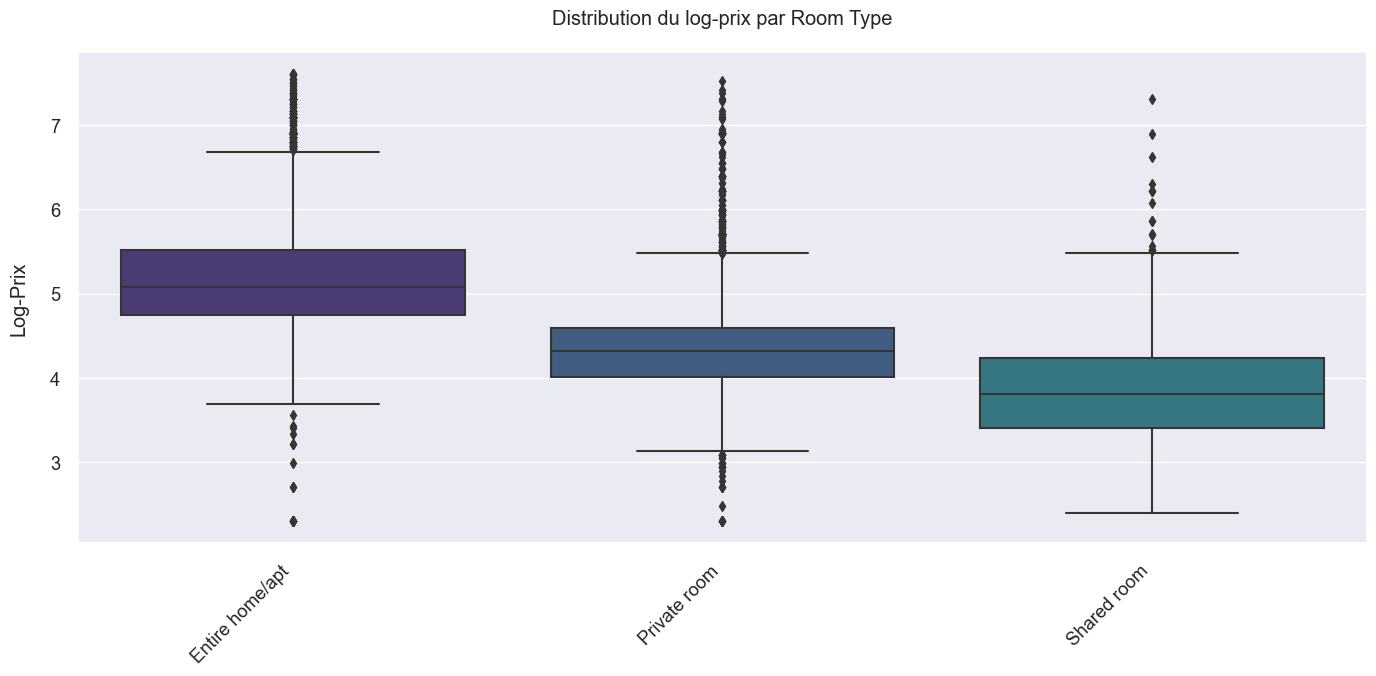

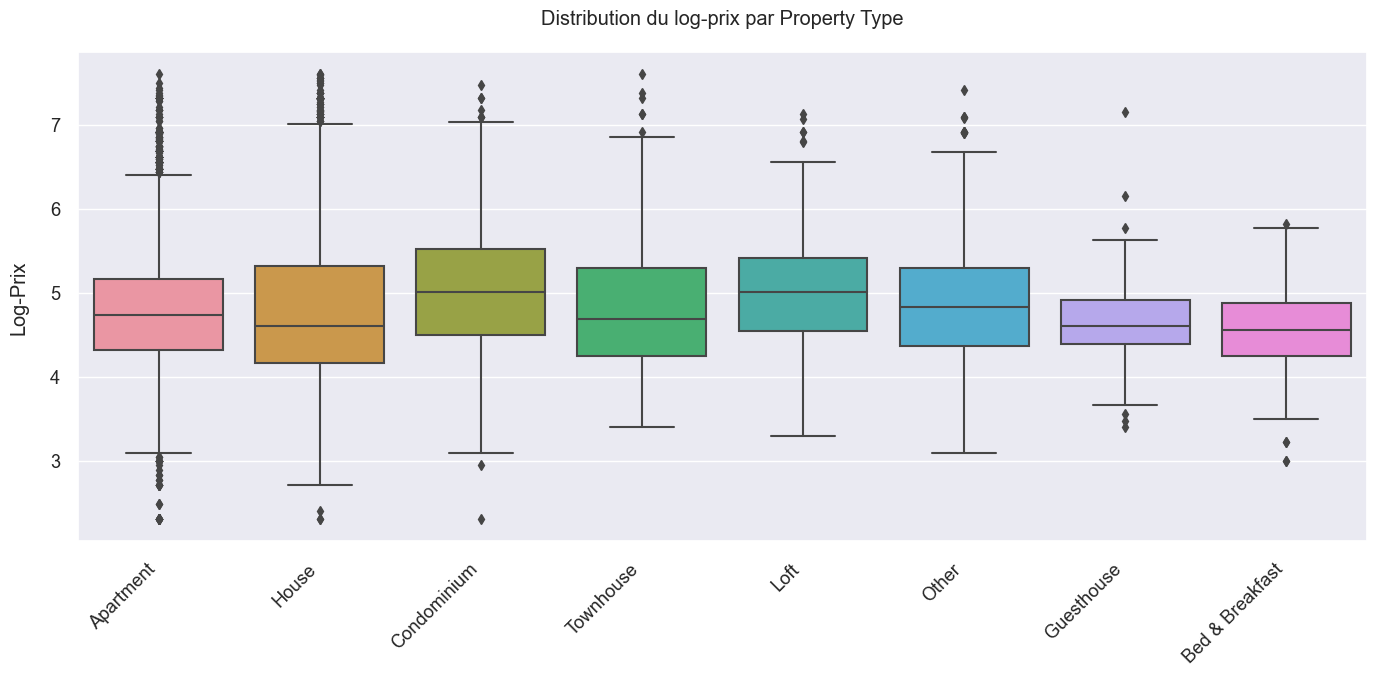

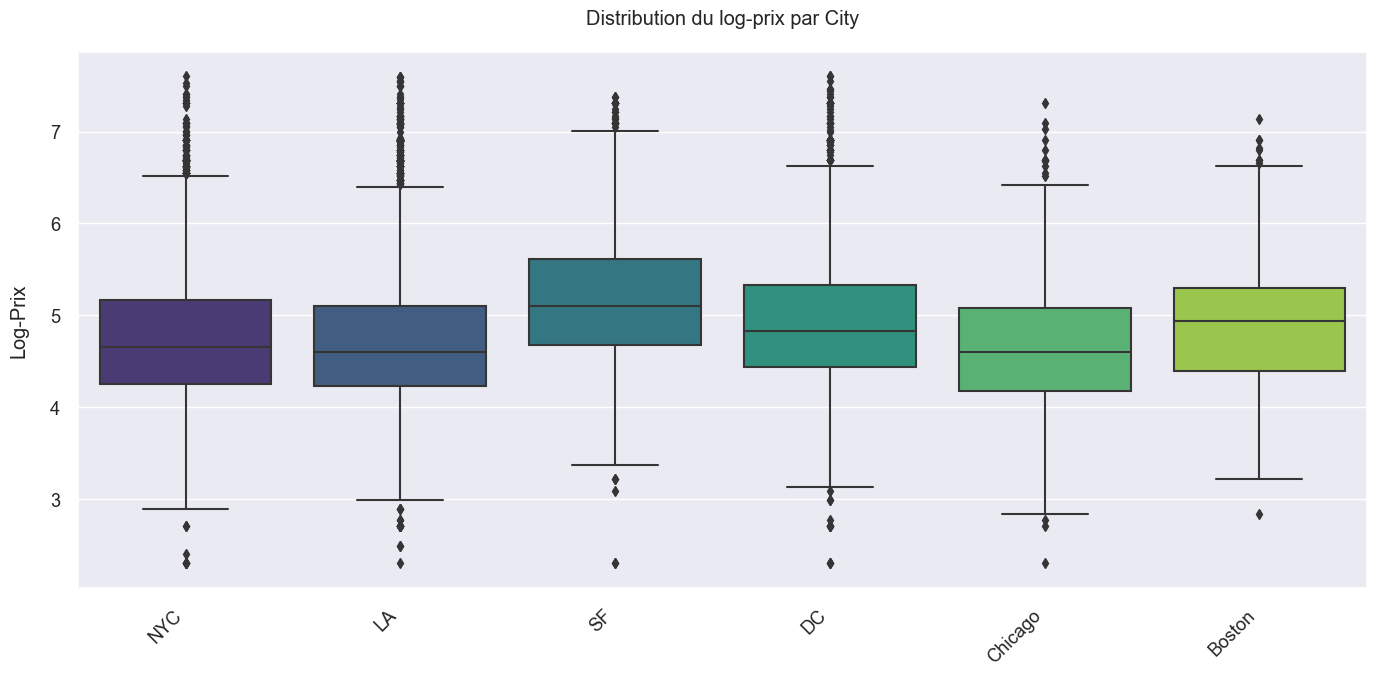

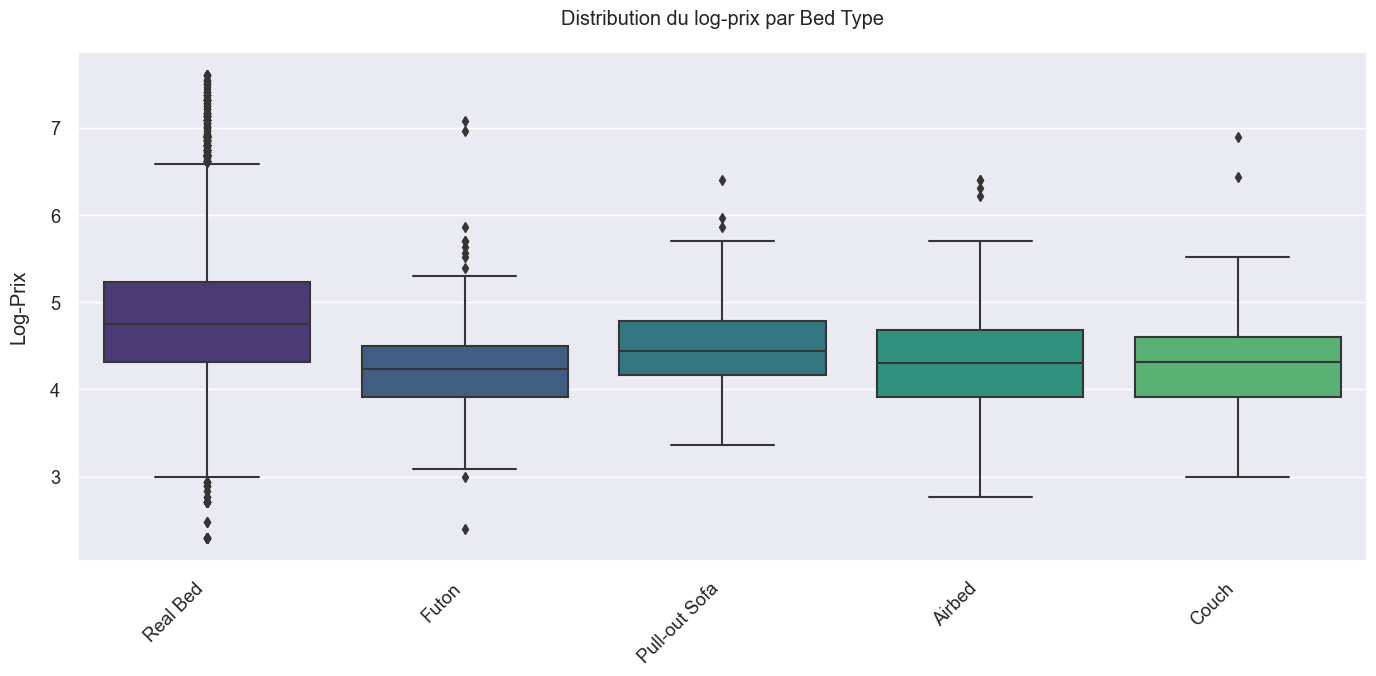

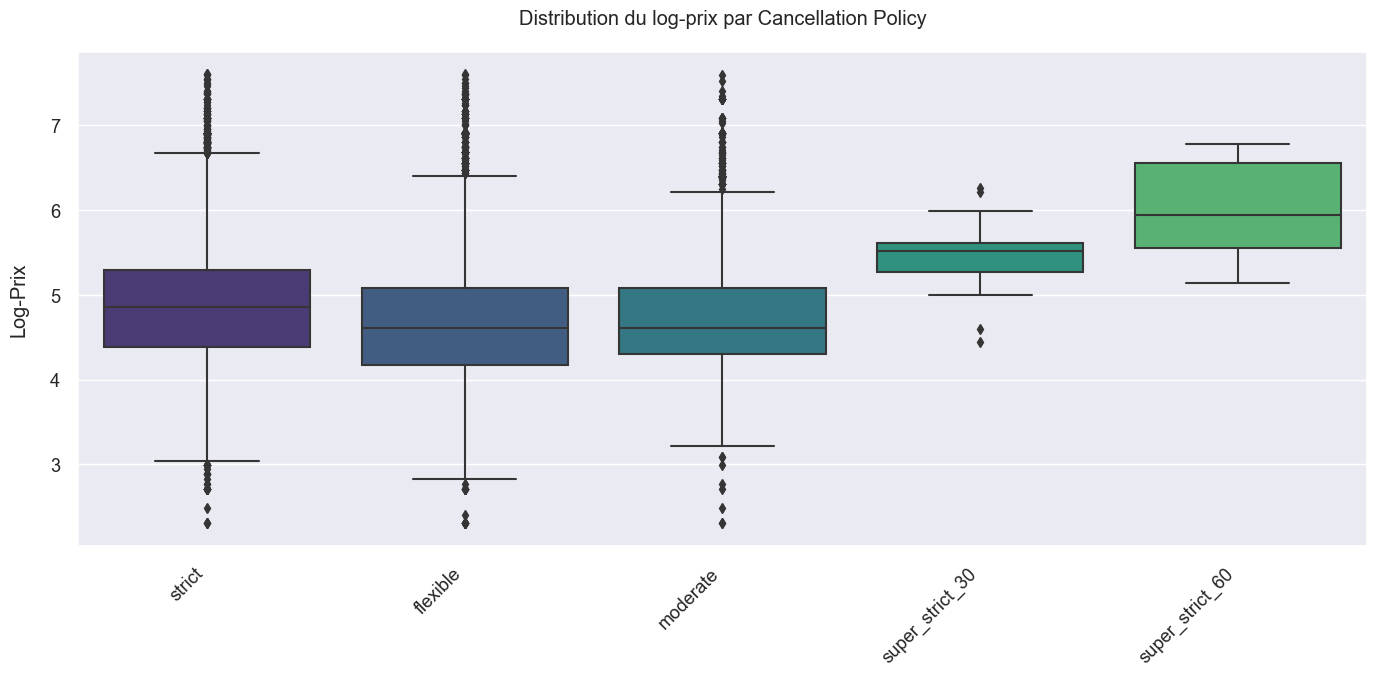

In [12]:
# Configuration commune
PLOT_SETTINGS = {
    "figsize": (14, 7),
    "palette": "viridis",
    "font_scale": 1.2
}
sns.set_theme(
    palette=PLOT_SETTINGS["palette"],
    font_scale=PLOT_SETTINGS["font_scale"],
    rc={"figure.figsize": PLOT_SETTINGS["figsize"]}
)

def plot_categorical_impact(data, categorical_col, top_n=8):
    """Visualise l'impact d'une variable catégorielle sur le log-prix"""
    # Filtre des catégories fréquentes
    counts = data[categorical_col].value_counts()
    filtered_data = data[data[categorical_col].isin(counts.nlargest(top_n).index)]
    
    # Création du graphique
    plt.figure(figsize=PLOT_SETTINGS["figsize"])
    ax = sns.boxplot(
        x=categorical_col, 
        y="log_price", 
        data=filtered_data,
        order=counts.nlargest(top_n).index
    )
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Distribution du log-prix par {categorical_col.replace('_', ' ').title()}", pad=20)
    plt.xlabel("")
    plt.ylabel("Log-Prix", labelpad=15)
    plt.tight_layout()
    return ax

# Analyse des principales caractéristiques
categorical_features = [
    "room_type",
    "property_type",
    "city", 
    "bed_type",
    "cancellation_policy"
]

for feature in categorical_features:
    plot_categorical_impact(train_data, feature)
    plt.show()

9. Analyse des corrélations numériques

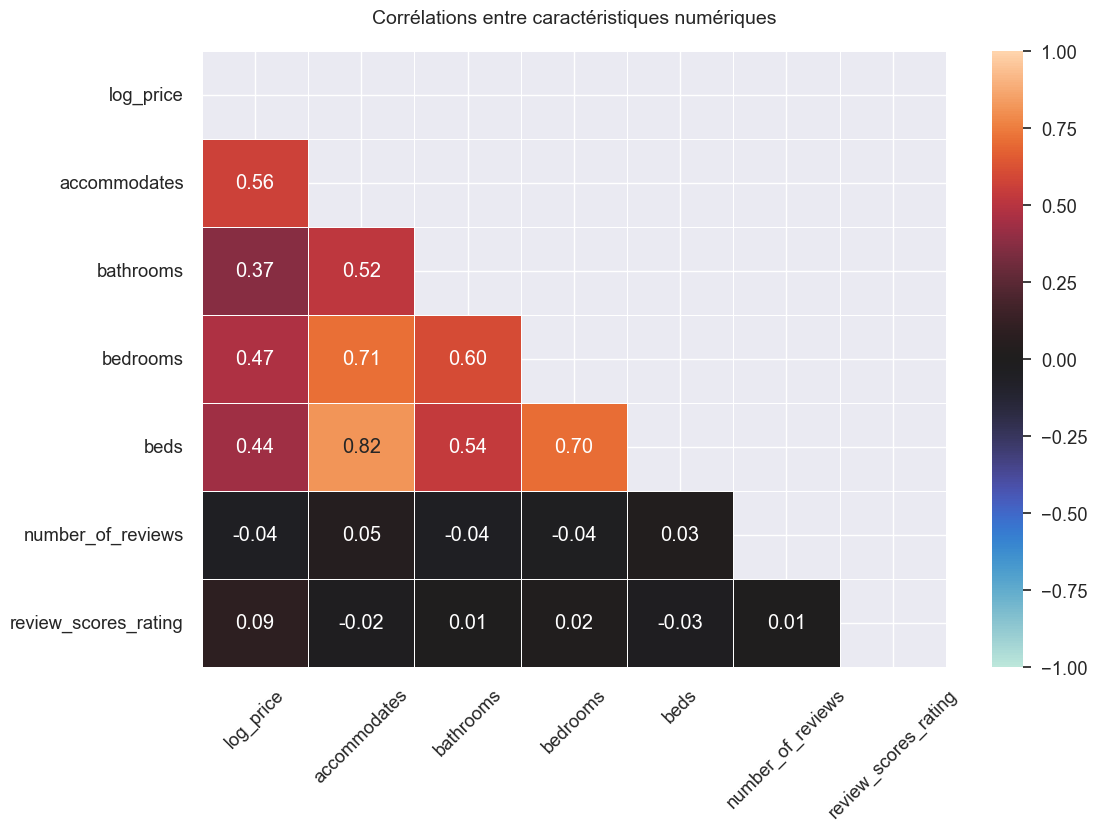

In [13]:
# Sélection des variables clés
numerical_features = [
    "log_price", 
    "accommodates", 
    "bathrooms", 
    "bedrooms", 
    "beds",
    "number_of_reviews", 
    "review_scores_rating"
]

# Matrice de corrélation améliorée
plt.figure(figsize=(12, 8))
corr_matrix = train_data[numerical_features].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Masquer la moitié supérieure

sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap="icefire", 
    fmt=".2f", 
    linewidths=0.5,
    mask=mask,
    vmin=-1, 
    vmax=1
)
plt.title("Corrélations entre caractéristiques numériques", fontsize=14, pad=20)
plt.xticks(rotation=45)
plt.show()

Log_price est significativement lié à bathrooms (0.37) et bedrooms (0.47)

10. Analyse géospatiale

C:\Users\saute\AppData\Local\Temp\ipykernel_29908\2571288756.py:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Log-prix")


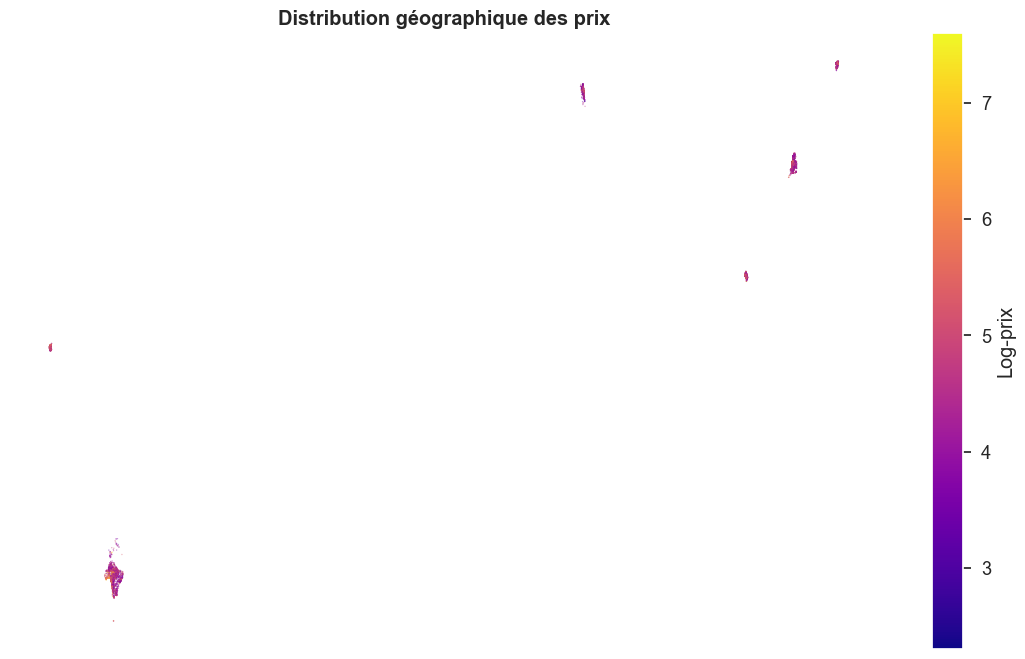

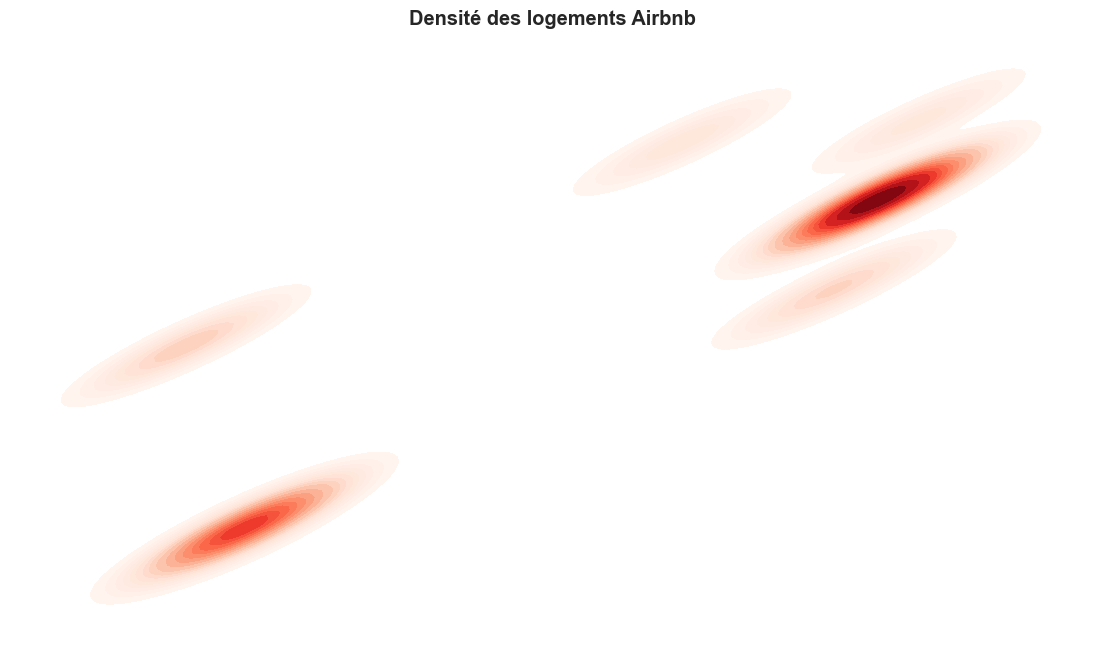

In [19]:
# Configuration des cartes
GEO_SETTINGS = {
    "figsize": (14, 8),
    "alpha": 0.4,
    "edgecolor": "none",
    "cmap": "plasma"
}

# Carte des prix
plt.figure(figsize=GEO_SETTINGS["figsize"])
ax = sns.scatterplot(
    data=train_data,
    x="longitude", 
    y="latitude",
    hue="log_price",
    palette=GEO_SETTINGS["cmap"],
    alpha=GEO_SETTINGS["alpha"],
    edgecolor=GEO_SETTINGS["edgecolor"],
    s=1,
    legend=False  # désactiver la légende automatique
)
norm = plt.Normalize(train_data["log_price"].min(), train_data["log_price"].max())
sm = plt.cm.ScalarMappable(cmap=GEO_SETTINGS["cmap"], norm=norm)
sm.set_array([])  # Obligatoire pour certains backends
plt.colorbar(sm, label="Log-prix")
plt.title("Distribution géographique des prix", fontweight='bold')
plt.axis("off")
plt.show()

# Carte de densité
plt.figure(figsize=GEO_SETTINGS["figsize"])
sns.kdeplot(
    x="longitude", 
    y="latitude", 
    data=train_data,
    fill=True, 
    thresh=0.05, 
    levels=20,
    cmap="Reds"
)
plt.title("Densité des logements Airbnb", fontweight='bold')
plt.axis("off")
plt.show()

11. Feature Engineering des catégories

In [20]:
# Encodage One-Hot standard
cat_features = ["room_type", "cancellation_policy", "property_type", "bed_type", "city"]
train_encoded = pd.get_dummies(train_data[cat_features], drop_first=True, prefix_sep=":")

# Encodage intelligent des équipements
def process_amenities(s):
    """Nettoie et structure la colonne amenities"""
    return set(s.strip("{}").replace('"', '').split(",")) if pd.notnull(s) else set()

# Application vectorisée
train_data["amenities"] = train_data["amenities"].apply(process_amenities)

# Création d'un DataFrame d'équipements
all_amenities = set.union(*train_data["amenities"])
amenities_df = pd.DataFrame(
    [[amenity in s for amenity in all_amenities] for s in train_data["amenities"]],
    columns=list(all_amenities)
).add_prefix("amenity:")

# Fusion finale
train_final = pd.concat([train_data, train_encoded, amenities_df], axis=1)

12. Validation d'impact des équipements

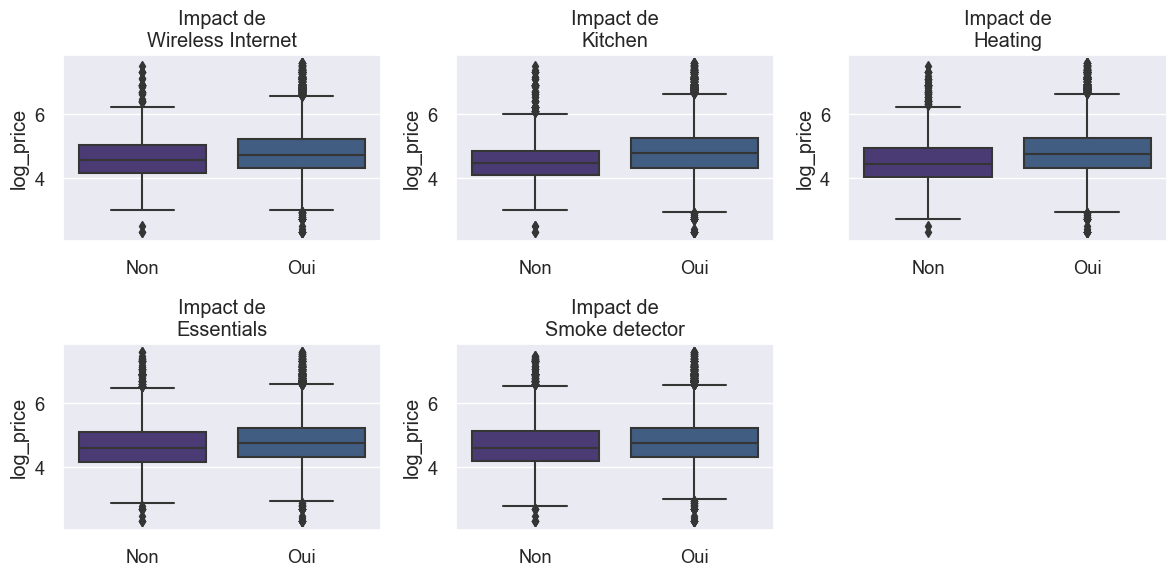

In [21]:
# Analyse automatique des équipements influents
top_amenities = amenities_df.sum().nlargest(5).index.tolist()

plt.figure(figsize=(12, 6))
for i, amenity in enumerate(top_amenities, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=amenities_df[amenity], y=train_data["log_price"])
    plt.title(f"Impact de\n{amenity.split(':')[1]}")
    plt.xlabel("")
    plt.xticks([0, 1], ["Non", "Oui"])
plt.tight_layout()
plt.show()

13. Analyse des équipements clés

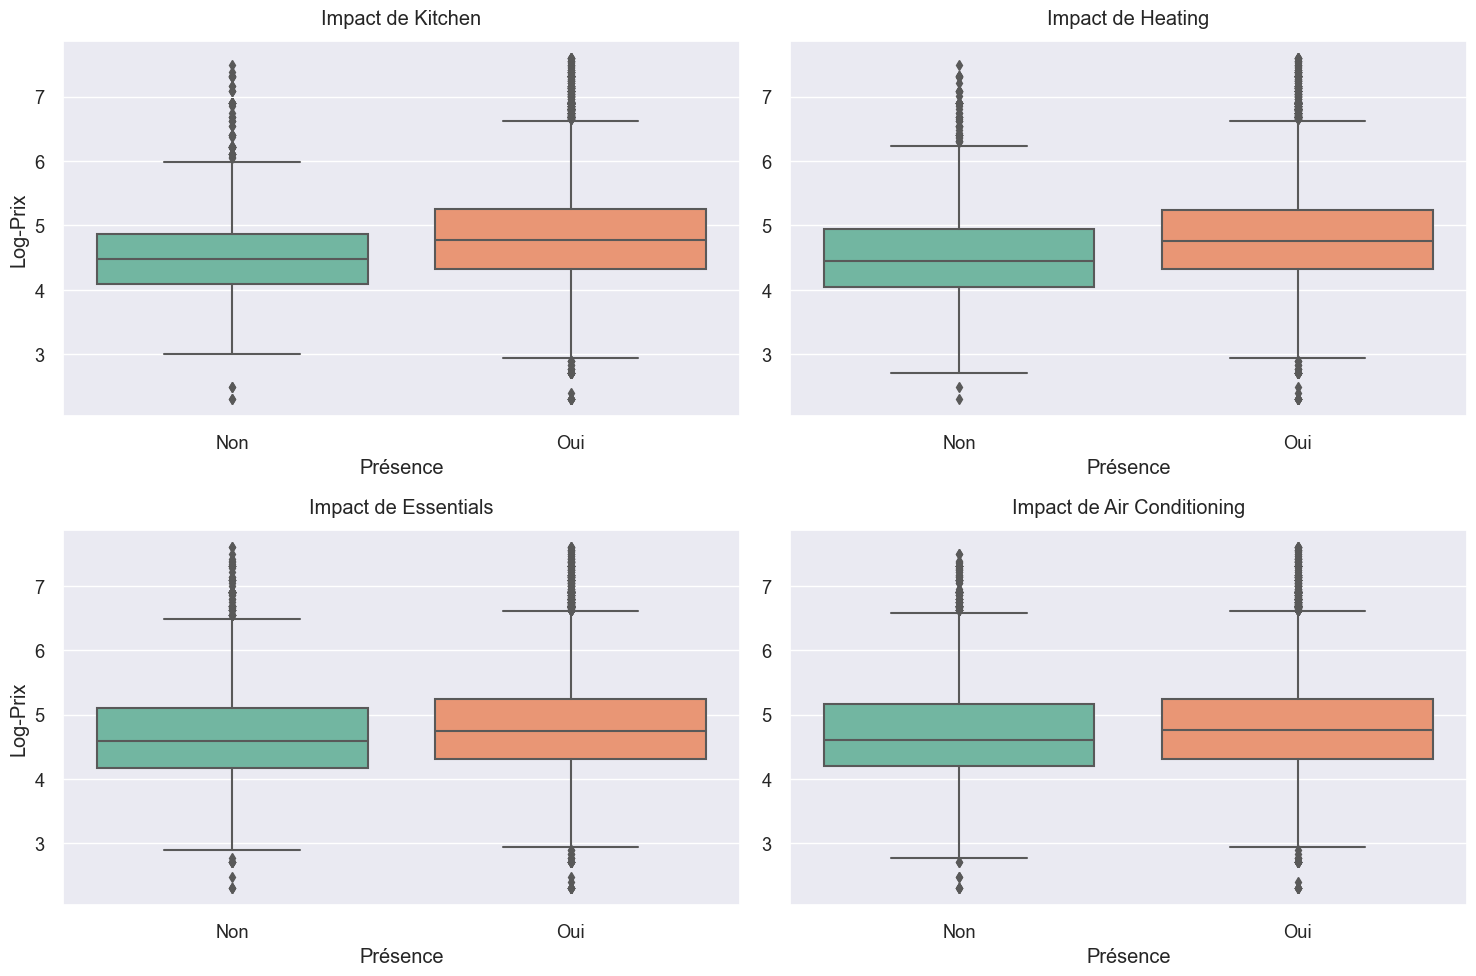

In [25]:
def plot_amenity_impact(amenity_list):
    plt.figure(figsize=(15, 10))
    n_plots = min(len(amenity_list), 4)
    i = 1
    for amenity in amenity_list:
        col_name = f"amenity:{amenity.replace('_', ' ')}"
        if col_name not in train_final.columns:
            print(f"⚠️ Colonne manquante : {col_name}")
            continue
        plt.subplot(2, 2, i)
        sns.boxplot(
            x=train_final[col_name],
            y=train_final["log_price"],
            palette="Set2"
        )
        plt.title(f"Impact de {amenity.replace('_', ' ').title()}", pad=12)
        plt.xlabel("Présence")
        plt.xticks([0, 1], ["Non", "Oui"])
        plt.ylabel("Log-Prix" if i % 2 == 1 else "")
        i += 1
    plt.tight_layout()
    plt.show()
# Analyse des équipements significatifs
significant_amenities = ["Kitchen", "Heating", "Essentials", "Air_conditioning"]
plot_amenity_impact(significant_amenities)

14. Analyse géographique avancée

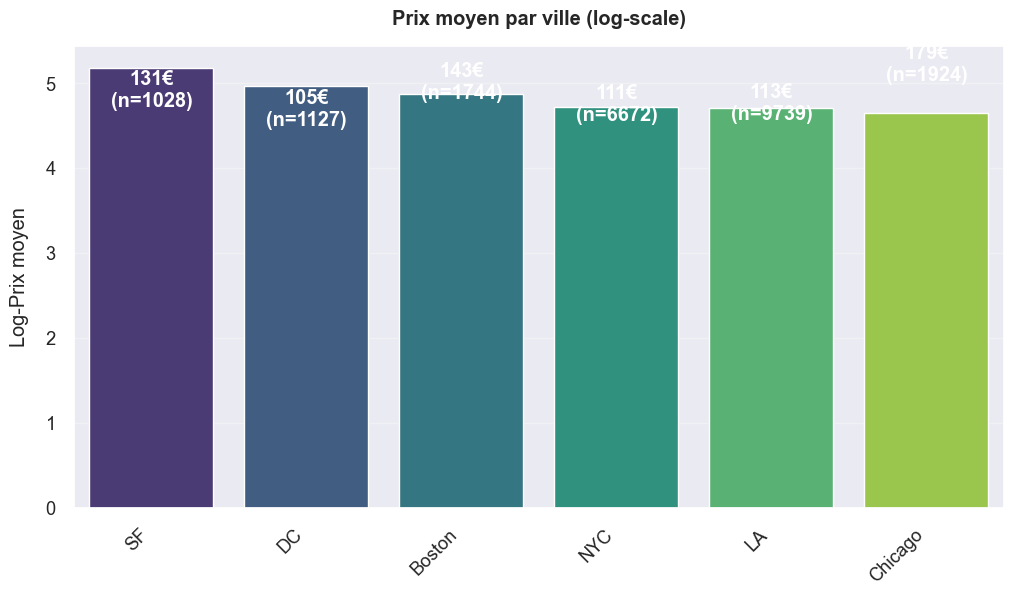

In [26]:
# Prix moyen par ville avec palette thermique
city_prices = train_data.groupby("city")["log_price"].agg(["mean", "count"])
city_prices = city_prices[city_prices["count"] > 50]  # Filtre des petites villes

plt.figure(figsize=(12, 6))
sns.barplot(
    x=city_prices.index,
    y="mean",
    data=city_prices,
    palette="viridis",
    order=city_prices.sort_values("mean", ascending=False).index
)
plt.title("Prix moyen par ville (log-scale)", fontweight="bold", pad=15)
plt.xlabel("")
plt.ylabel("Log-Prix moyen", labelpad=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Annotation des valeurs
for idx, (price, count) in enumerate(zip(city_prices["mean"], city_prices["count"])):
    plt.text(
        idx, 
        price-0.15, 
        f"{np.exp(price):.0f}€\n(n={count})", 
        ha='center', 
        color='white',
        fontweight='bold'
    )
    
plt.show()

15. Analyse croisée des politiques d'annulation

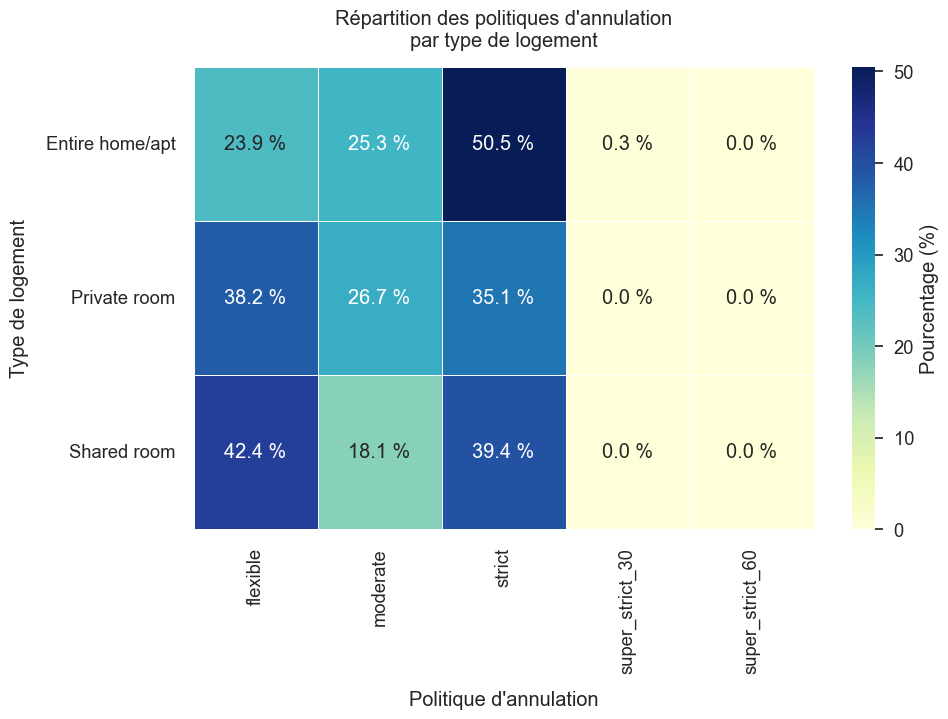

In [28]:
# Heatmap normalisée en pourcentages
cross_tab = pd.crosstab(
    train_data["room_type"], 
    train_data["cancellation_policy"],
    normalize="index"
) * 100

# Annot avec pourcentages formatés en texte
annot = cross_tab.round(1).astype(str) + " %"

plt.figure(figsize=(10, 6))
sns.heatmap(
    cross_tab,
    annot=annot,
    fmt="",  # Pas de formatage car déjà formaté manuellement
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={'label': 'Pourcentage (%)'}
)
plt.title("Répartition des politiques d'annulation\npar type de logement", pad=15)
plt.xlabel("Politique d'annulation", labelpad=12)
plt.ylabel("Type de logement", labelpad=12)
plt.yticks(rotation=0)
plt.show()
